In [1]:
## Imports

import csv
import numbers
import os
import random
import json
from collections import OrderedDict, defaultdict
from copy import deepcopy
from pathlib import Path
from typing import *
from datetime import datetime, timezone

import flwr as fl
import ray
import gdown
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from flwr.common import Metrics
from flwr.common.parameter import ndarrays_to_parameters
from flwr.common.typing import NDArrays, Parameters, Scalar
from flwr.server import ServerConfig
from flwr.server.server import Server
from flwr.server.strategy import FedAvgM as FedAvg
from flwr.server.client_manager import SimpleClientManager
from PIL import Image
from PIL.Image import Image as ImageType
from torch.nn import Module
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from tqdm import tqdm
from enum import IntEnum


# Add new seeds here for easy autocomplete
class Seeds(IntEnum):
    DEFAULT = 1337

np.random.seed(Seeds.DEFAULT)
random.seed(Seeds.DEFAULT)
torch.manual_seed(Seeds.DEFAULT)
torch.backends.cudnn.benchmark = False # type: ignore
torch.backends.cudnn.deterministic = True # type: ignore

def convert(o):
    if isinstance(o, np.int64) or isinstance(o, np.int32): return int(o)  
    if isinstance(o, np.float32) or isinstance(o, np.float64): return float(o)  
    raise TypeError

def save_history(hist, name):
  time = int(datetime.now(timezone.utc).timestamp())
  with open(home_dir / "histories" / f"hist_{time}_{name}.json", "w", encoding="utf-8") as f:
            json.dump(hist.__dict__, f, ensure_ascii=False, indent=4, default=convert)

def start_seeded_simulation(
    client_fn,
    num_clients,
    client_resources,
    server,
    config,
    strategy,
    name: str,
    seed: int = Seeds.DEFAULT,
):
    """Wrapper to always seed client selection."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    hist =  fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=num_clients,
        client_resources=client_resources,
        server=server,
        config=config,
        strategy=strategy,
    )
    save_history(hist, name)
    ray.shutdown()
    return hist

def fit_client_seeded(client, params, conf, seed=Seeds.DEFAULT):
    """Wrapper to always seed client training."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    return client.fit(params, conf)

PathType = Optional[Union[Path, str]]

def get_device() -> str:
    device = "cpu"
    # if torch.cuda.is_available():
    #     device = "cuda"
    # elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    #     device = "mps"
    return device

client_resources = {
    "num_gpus": 1.0/2 if get_device() == 'cuda' else 0.0, # maximum amount of resources that a client can take
}

/home/pranav/.local/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
home_dir = Path("content")
dataset_dir: Path = home_dir / "femnist"
data_dir: Path = dataset_dir / "data"
centralized_partition: Path = dataset_dir / 'client_data_mappings' / 'centralized'
centralized_mapping: Path = dataset_dir / 'client_data_mappings' / 'centralized' / '0'
federated_partition: Path = dataset_dir / 'client_data_mappings' / 'fed_natural'

In [3]:
from femnist_dataset import FEMNIST
from client_utils import to_tensor_transform, get_network_generator_mlp, get_network_generator_cnn, get_model_parameters, Net, get_federated_evaluation_function, aggregate_weighted_average, get_default_train_config, get_default_test_config, get_federated_evaluation_function_with_recall
from client import FlowerRayClient, get_flower_client_generator
# import server
# from server import Server, NewHistory as History
# import client_manager
# from client_manager import CustomClientManager

In [4]:
torch.manual_seed(Seeds.DEFAULT)
network_generator_cnn = get_network_generator_cnn()
seed_net = network_generator_cnn()
seed_model_params: NDArrays = get_model_parameters(seed_net)
federated_evaluation_function = get_federated_evaluation_function(
    data_dir=data_dir,
    centralized_mapping=centralized_mapping,
    device=get_device(),
    batch_size=get_default_test_config()["batch_size"],
    num_workers=get_default_test_config()["num_workers"],
    model_generator=network_generator_cnn,
    criterion=nn.CrossEntropyLoss(),
)
train_config = get_default_train_config()
test_config = get_default_test_config()
num_total_clients = 3230

In [7]:
default_parameters: Dict = {
    "train_config": get_default_train_config(),
    "test_config": get_default_test_config(),
    "num_total_clients": num_total_clients,
    "num_fit_clients": 5,
    "num_evaluate_clients": 1,
    "accept_failures": False,
    "min_fit_clients": 1,
    "initial_parameters": ndarrays_to_parameters(seed_model_params),
    "seed": Seeds.DEFAULT,
    "num_rounds": 10,
    "strategy": FedAvg,
    "server_learning_rate": 1.0
}

def run_data_poisoning_fl(
    m: int,
    source_class: int,
    target_class: int,
    **kwargs
):
    parameters: Dict = {**default_parameters, **kwargs}

    on_fit_config_fn: Callable[[int], Dict[str, Scalar]] = lambda cid: parameters[
        "train_config"
    ]
    on_evaluate_config_fn: Callable[[int], Dict[str, Scalar]] = lambda cid: parameters["test_config"]  # type: ignore

    fraction_fit: float = float(parameters["num_fit_clients"]) / parameters["num_total_clients"]
    fraction_evaluate: float = (
        float(parameters["num_evaluate_clients"]) / parameters["num_total_clients"]
    )

    client_resources = {
        "num_gpus": 1.0/2 if get_device() == 'cuda' else 0.0, # maximum amount of resources that a client can take
    }
    
    evaluate_fn = get_federated_evaluation_function_with_recall(
        data_dir=data_dir,
        centralized_mapping=centralized_mapping,
        device=get_device(),
        batch_size=get_default_test_config()["batch_size"],
        num_workers=get_default_test_config()["num_workers"],
        model_generator=network_generator_cnn,
        criterion=nn.CrossEntropyLoss(),
        source_class=source_class
    )

    strategy = parameters["strategy"](
        fraction_fit=fraction_fit,
        fraction_evaluate=fraction_evaluate,
        min_fit_clients=parameters["num_fit_clients"],
        min_available_clients=parameters["num_total_clients"],
        on_fit_config_fn=on_fit_config_fn,
        on_evaluate_config_fn=on_evaluate_config_fn,
        evaluate_fn=evaluate_fn,
        initial_parameters=parameters["initial_parameters"],
        accept_failures=parameters["accept_failures"],
        fit_metrics_aggregation_fn=aggregate_weighted_average,
        evaluate_metrics_aggregation_fn=aggregate_weighted_average,
        server_learning_rate=parameters["server_learning_rate"],
    )
    
    random.seed(parameters["seed"])
    if m:
        malicious_clients = random.sample(range(num_total_clients), int(num_total_clients*m))
    else:
        malicious_clients = []
        
    server = Server(
        client_manager=SimpleClientManager(),
        strategy=strategy
    )

    def target_transform(p):
        for i, val in p:
            if val == source_class:
                p[i] = target_class
            if val == target_class:
                p[i] = source_class

    malicious_client_generator: Callable[
        [int], FlowerRayClient
    ] = get_flower_client_generator(network_generator_cnn, data_dir, federated_partition, malicious_clients, target_transform)
    
    return start_seeded_simulation(
        client_fn=malicious_client_generator,
        num_clients=parameters["num_total_clients"],
        client_resources=client_resources,
        server=server,
        config=ServerConfig(num_rounds=parameters["num_rounds"]),
        strategy=strategy,
        seed=parameters["seed"],
        name=f"data_poisoning_m_{m}_source_{source_class}_target_{target_class}"
    )

In [15]:
for m in [0, 0.01, 0.02, 0.05, 0.1, 0.25]:
    run_data_poisoning_fl(
        m=m,
        source_class=1,
        target_class=18,
        num_fit_clients=50,
        num_rounds=10
    )

 88%|████████▊ | 7/8 [00:01<00:00,  5.47it/s]
DEBUG flwr 2023-03-30 09:22:31,091 | server.py:229 | fit_round 6 received 50 results and 0 failures
100%|██████████| 891/891 [00:03<00:00, 277.90it/s]
INFO flwr 2023-03-30 09:22:34,363 | server.py:116 | fit progress: (6, 2641.5180529356003, {'accuracy': 0.28933707471062786, 'recall': 0.7255295465222646}, 95.00766022599782)
DEBUG flwr 2023-03-30 09:22:34,363 | server.py:165 | evaluate_round 6: strategy sampled 2 clients (out of 3230)
  0%|          | 0/2 [00:00<?, ?it/s]817) 
DEBUG flwr 2023-03-30 09:22:34,446 | server.py:179 | evaluate_round 6 received 2 results and 0 failures
INFO flwr 2023-03-30 09:22:34,447 | fedavg.py:184 | sample_size: 50, min_num_clients: 3230, num_available: 3230
DEBUG flwr 2023-03-30 09:22:34,447 | server.py:215 | fit_round 7: strategy sampled 50 clients (out of 3230)
 88%|████████▊ | 7/8 [00:01<00:00,  4.69it/s]
DEBUG flwr 2023-03-30 09:22:46,410 | server.py:229 | fit_round 7 received 50 results and 0 failures
100%

0.5564012627148369
0.4980007015082427
0.46674850929498424
0.4919326552086987
0.5614170466502981
0.49508944230094704


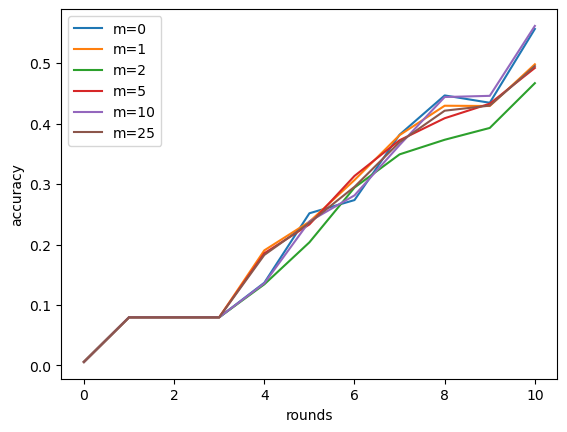

In [16]:
history_files = [
    'hist_1680160832_data_poisoning_m_0.json',
    'hist_1680161003_data_poisoning_m_0.01.json',
    'hist_1680161177_data_poisoning_m_0.02.json',
    'hist_1680161348_data_poisoning_m_0.05.json',
    'hist_1680161518_data_poisoning_m_0.1.json',
    'hist_1680161686_data_poisoning_m_0.25.json'
]
for fname, m in zip(history_files, [0, 1, 2, 5, 10, 25]):
    with open(home_dir / 'histories' / fname) as f:
        hist = json.load(f)
    accuracy = list(map(lambda val: val[1], hist['metrics_centralized']['accuracy']))
    print(accuracy[-1])
    plt.plot(accuracy, label=f'm={m}')
plt.xlabel('rounds')
plt.ylabel('accuracy')
plt.legend()
plt.show()


0.508097288132918
0.45986585606696495
0.48913651665486607
0.49544786654337486
0.4940908217570597
0.4916003081366403


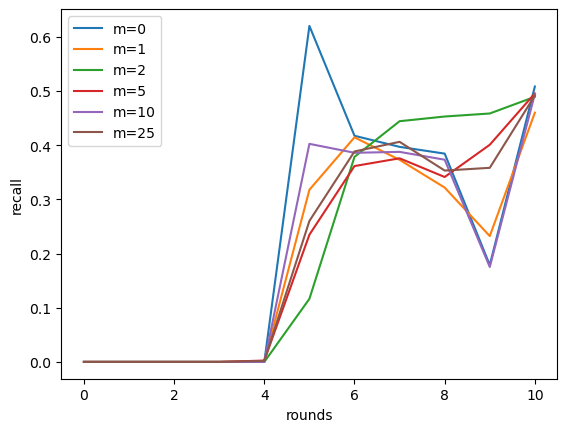

In [17]:
history_files = [
    'hist_1680160832_data_poisoning_m_0.json',
    'hist_1680161003_data_poisoning_m_0.01.json',
    'hist_1680161177_data_poisoning_m_0.02.json',
    'hist_1680161348_data_poisoning_m_0.05.json',
    'hist_1680161518_data_poisoning_m_0.1.json',
    'hist_1680161686_data_poisoning_m_0.25.json'
]
for fname, m in zip(history_files, [0, 1, 2, 5, 10, 25]):
    with open(home_dir / 'histories' / fname) as f:
        hist = json.load(f)
    recall = list(map(lambda val: val[1], hist['metrics_centralized']['recall']))
    print(recall[-1])
    plt.plot(recall, label=f'm={m}')
plt.xlabel('rounds')
plt.ylabel('recall')
plt.legend()
plt.show()

0.5243774114345844
0.534093300596282
0.46517011574886
0.46990529638723255
0.5268677656962469
0.5453174324798317


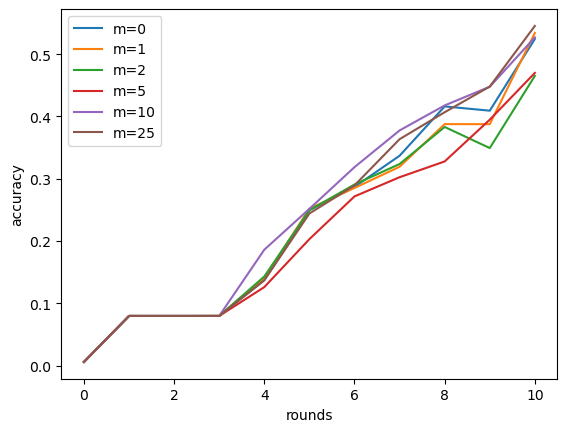

In [18]:
history_files = [
    'hist_1680163767_data_poisoning_m_0_source_1_target_18.json',
    'hist_1680163938_data_poisoning_m_0.01_source_1_target_18.json',
    'hist_1680164109_data_poisoning_m_0.02_source_1_target_18.json',
    'hist_1680164278_data_poisoning_m_0.05_source_1_target_18.json',
    'hist_1680164451_data_poisoning_m_0.1_source_1_target_18.json',
    'hist_1680164617_data_poisoning_m_0.25_source_1_target_18.json'
]
for fname, m in zip(history_files, [0, 1, 2, 5, 10, 25]):
    with open(home_dir / 'histories' / fname) as f:
        hist = json.load(f)
    accuracy = list(map(lambda val: val[1], hist['metrics_centralized']['accuracy']))
    print(accuracy[-1])
    plt.plot(accuracy, label=f'm={m}')
plt.xlabel('rounds')
plt.ylabel('accuracy')
plt.legend()
plt.show()

0.47427671968803126
0.4902695399342161
0.36569130636425534
0.3085542394373018
0.5050300198171275
0.4333132934975035


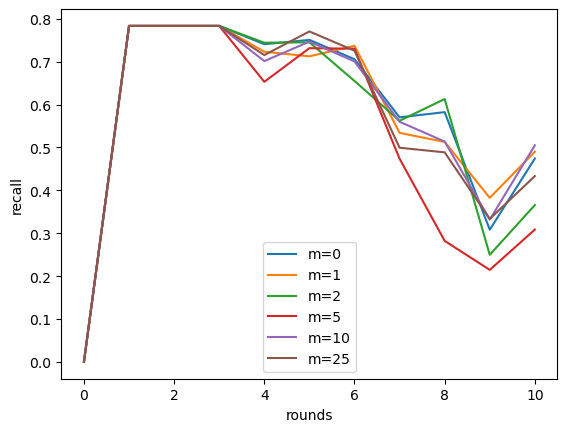

In [19]:
history_files = [
    'hist_1680163767_data_poisoning_m_0_source_1_target_18.json',
    'hist_1680163938_data_poisoning_m_0.01_source_1_target_18.json',
    'hist_1680164109_data_poisoning_m_0.02_source_1_target_18.json',
    'hist_1680164278_data_poisoning_m_0.05_source_1_target_18.json',
    'hist_1680164451_data_poisoning_m_0.1_source_1_target_18.json',
    'hist_1680164617_data_poisoning_m_0.25_source_1_target_18.json'
]
for fname, m in zip(history_files, [0, 1, 2, 5, 10, 25]):
    with open(home_dir / 'histories' / fname) as f:
        hist = json.load(f)
    recall = list(map(lambda val: val[1], hist['metrics_centralized']['recall']))
    print(recall[-1])
    plt.plot(recall, label=f'm={m}')
plt.xlabel('rounds')
plt.ylabel('recall')
plt.legend()
plt.show()

In [5]:
from dp import *

In [8]:
adaptive_default_parameters: Dict = {
    "train_config": get_default_train_config(),
    "test_config": get_default_test_config(),
    "num_total_clients": num_total_clients,
    "num_clients_per_round": 50,
    "num_evaluate_clients": 1,
    "accept_failures": False,
    "min_fit_clients": 50,
    "min_available_clients": 50,
    "initial_parameters": ndarrays_to_parameters(seed_model_params),
    "seed": Seeds.DEFAULT,
    "num_rounds": 20,
    "strategy": DPFedAvgAdaptive,
    "fed_eval": True,
    "server_side_noising": True,
    "clip_count_stddev": None,
}


def run_poisoning_with_DP_adaptive_fl(
    m: int,
    source_class: int,
    target_class: int,
    noise_multiplier: float = 0,
    init_clip_norm: float = 2,
    clip_norm_lr: float = 0.2,
    clip_norm_target_quantile: float = 0.5,
    default_parameters=adaptive_default_parameters,
    **kwargs
):
    parameters: Dict = {**default_parameters, **kwargs}

    on_fit_config_fn: Callable[[int], Dict[str, Scalar]] = lambda cid: parameters[
        "train_config"
    ]
    on_evaluate_config_fn: Callable[[int], Dict[str, Scalar]] = lambda cid: parameters["test_config"]  # type: ignore

    fraction_fit: float = (
        float(parameters["num_clients_per_round"]) / parameters["num_total_clients"]
    )
    fraction_evaluate: float = (
        float(parameters["num_evaluate_clients"]) / parameters["num_total_clients"]
    )

    client_resources = {
        "num_gpus": 1.0 / 2.0
        if get_device() == "cuda"
        else 0.0,  # maximum amount of resources that a client can take
        "num_cpus": 1,
    }
    
    random.seed(parameters["seed"])
    if m:
        malicious_clients = random.sample(range(num_total_clients), int(num_total_clients*m))
    else:
        malicious_clients = []
        
    def target_transform(p):
        for i, val in p:
            if val == source_class:
                p[i] = target_class
            if val == target_class:
                p[i] = source_class

    dp_client_generator = get_DP_client_generator(
        network_generator_cnn, data_dir, federated_partition, malicious_clients, target_transform
    )
    
    evaluate_fn = get_federated_evaluation_function_with_recall(
        data_dir=data_dir,
        centralized_mapping=centralized_mapping,
        device=get_device(),
        batch_size=get_default_test_config()["batch_size"],
        num_workers=get_default_test_config()["num_workers"],
        model_generator=network_generator_cnn,
        criterion=nn.CrossEntropyLoss(),
        source_class=source_class
    )

    strategy = parameters["strategy"](
        num_clients_per_round=parameters["num_clients_per_round"],
        fraction_fit=fraction_fit,
        fraction_evaluate=fraction_evaluate,
        min_fit_clients=parameters["min_fit_clients"],
        min_available_clients=parameters["min_available_clients"],
        on_fit_config_fn=on_fit_config_fn,
        on_evaluate_config_fn=on_evaluate_config_fn,
        initial_parameters=parameters["initial_parameters"],
        accept_failures=parameters["accept_failures"],
        evaluate_fn=evaluate_fn
        if parameters["fed_eval"] is True
        else None,
        fit_metrics_aggregation_fn=aggregate_weighted_average,
        evaluate_metrics_aggregation_fn=aggregate_weighted_average,
        init_clip_norm=init_clip_norm,
        clip_norm_lr=clip_norm_lr,
        clip_norm_target_quantile=clip_norm_target_quantile,
        noise_multiplier=noise_multiplier,
        server_side_noising=parameters["server_side_noising"],
        clip_count_stddev=parameters["clip_count_stddev"],
    )
    client_manager = CustomClientManager(criterion=None, seed=parameters["seed"])
    server = Server(
        client_manager=client_manager,
        strategy=strategy,
    )
    return start_seeded_simulation(
        client_fn=dp_client_generator,
        num_clients=parameters["num_total_clients"],
        client_resources=client_resources,
        server=server,
        config=ServerConfig(num_rounds=parameters["num_rounds"]),
        strategy=strategy,
        seed=parameters["seed"],
        name=f"adaptive_target_{clip_norm_target_quantile}_init_clip_norm_{init_clip_norm}_lr_{clip_norm_lr}_noise_{noise_multiplier}"
    )

In [10]:
for m in [0.01, 0.02, 0.05, 0.1, 0.25]:
    run_poisoning_with_DP_adaptive_fl(m=0, source_class=1, target_class=18)

100%|██████████| 8/8 [00:01<00:00,  4.57it/s]
DEBUG flwr 2023-03-30 10:57:16,089 | server.py:229 | fit_round 18 received 50 results and 0 failures
100%|██████████| 891/891 [00:03<00:00, 287.75it/s]
INFO flwr 2023-03-30 10:57:19,368 | server.py:116 | fit progress: (18, 1861.7794480919838, {'accuracy': 0.5437039635215714, 'recall': 0.7240451256066193}, 271.99518910900224)
INFO flwr 2023-03-30 10:57:19,381 | client_manager.py:49 | Sampling using None
DEBUG flwr 2023-03-30 10:57:19,381 | server.py:165 | evaluate_round 18: strategy sampled 2 clients (out of 3230)
  0%|          | 0/1 [00:00<?, ?it/s]1094) 
DEBUG flwr 2023-03-30 10:57:19,483 | server.py:179 | evaluate_round 18 received 2 results and 0 failures
INFO flwr 2023-03-30 10:57:19,501 | client_manager.py:49 | Sampling using None
100%|██████████| 2/2 [00:00<00:00, 23.39it/s]m 
DEBUG flwr 2023-03-30 10:57:19,502 | server.py:215 | fit_round 19: strategy sampled 50 clients (out of 3230)
100%|██████████| 1/1 [00:00<00:00, 16.73it/s]m 


Sampled the following clients:  ['675', '1963']
Sampled the following clients:  ['723', '903', '1137', '343', '2218', '163', '2348', '1459', '605', '2403', '527', '2404', '2167', '921', '569', '1011', '2713', '2671', '629', '677', '1458', '2882', '1140', '1322', '2162', '762', '548', '1433', '3228', '2470', '2391', '225', '2516', '2337', '1733', '1876', '1281', '1571', '908', '1188', '2406', '2930', '2075', '2733', '287', '1116', '583', '2303', '1002', '3200']


 88%|████████▊ | 7/8 [00:01<00:00,  5.00it/s]
DEBUG flwr 2023-03-30 10:57:31,192 | server.py:229 | fit_round 19 received 50 results and 0 failures
100%|██████████| 891/891 [00:03<00:00, 279.57it/s]
INFO flwr 2023-03-30 10:57:34,562 | server.py:116 | fit progress: (19, 1783.2991106510162, {'accuracy': 0.5624342336022449, 'recall': 0.7133188151182684}, 287.1896416870004)
INFO flwr 2023-03-30 10:57:34,578 | client_manager.py:49 | Sampling using None
DEBUG flwr 2023-03-30 10:57:34,579 | server.py:165 | evaluate_round 19: strategy sampled 2 clients (out of 3230)
DEBUG flwr 2023-03-30 10:57:34,661 | server.py:179 | evaluate_round 19 received 2 results and 0 failures
INFO flwr 2023-03-30 10:57:34,682 | client_manager.py:49 | Sampling using None
100%|██████████| 1/1 [00:00<00:00, 17.86it/s]m 
DEBUG flwr 2023-03-30 10:57:34,683 | server.py:215 | fit_round 20: strategy sampled 50 clients (out of 3230)
100%|██████████| 1/1 [00:00<00:00, 15.43it/s]m 


Sampled the following clients:  ['723', '903']
Sampled the following clients:  ['1174', '1152', '2447', '236', '1298', '2939', '1053', '2496', '2375', '3112', '1819', '2635', '1939', '2655', '1297', '2012', '3136', '2664', '1630', '3101', '649', '1397', '3076', '643', '227', '1555', '1442', '1680', '1273', '1099', '1733', '3163', '2410', '147', '897', '2379', '179', '2863', '1132', '2213', '134', '2586', '2642', '799', '400', '1374', '700', '1892', '1258', '3121']


 88%|████████▊ | 7/8 [00:02<00:00,  4.39it/s]
DEBUG flwr 2023-03-30 10:57:46,497 | server.py:229 | fit_round 20 received 50 results and 0 failures
100%|██████████| 891/891 [00:03<00:00, 279.69it/s]
INFO flwr 2023-03-30 10:57:49,857 | server.py:116 | fit progress: (20, 1612.7508380711079, {'accuracy': 0.6032269379165205, 'recall': 0.7352497645399787}, 302.4843471179993)
INFO flwr 2023-03-30 10:57:49,874 | client_manager.py:49 | Sampling using None
DEBUG flwr 2023-03-30 10:57:49,874 | server.py:165 | evaluate_round 20: strategy sampled 2 clients (out of 3230)
  0%|          | 0/1 [00:00<?, ?it/s]1099) 
DEBUG flwr 2023-03-30 10:57:49,977 | server.py:179 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-03-30 10:57:49,978 | server.py:144 | FL finished in 302.6052245329993
INFO flwr 2023-03-30 10:57:49,979 | app.py:202 | app_fit: losses_distributed [(1, 4.137338876724243), (2, 6.873981793721517), (3, 6.768711090087891), (4, 3.8505873680114746), (5, 3.5857760906219482), (6

Sampled the following clients:  ['1174', '1152']


0.6032269379165205
0.6032269379165205
0.6032269379165205
0.6032269379165205
0.6032269379165205
0.6032269379165205


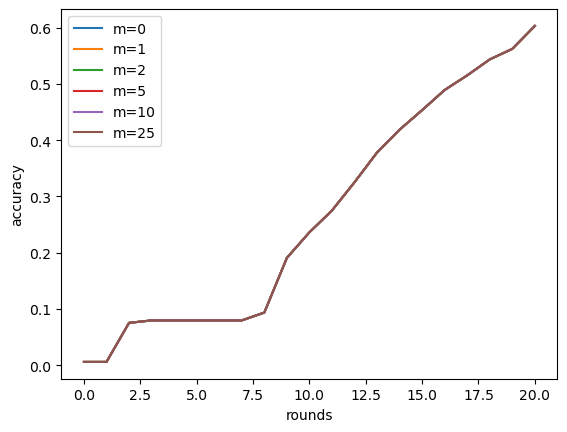

In [15]:
history_files = [
    'hist_1680168537_adaptive_target_0.5_init_clip_norm_2_lr_0.2_noise_0.json',
    'hist_1680169020_adaptive_target_0.5_init_clip_norm_2_lr_0.2_noise_0.json',
    'hist_1680169323_adaptive_target_0.5_init_clip_norm_2_lr_0.2_noise_0.json',
    'hist_1680169635_adaptive_target_0.5_init_clip_norm_2_lr_0.2_noise_0.json',
    'hist_1680169958_adaptive_target_0.5_init_clip_norm_2_lr_0.2_noise_0.json',
    'hist_1680170270_adaptive_target_0.5_init_clip_norm_2_lr_0.2_noise_0.json'
]
for fname, m in zip(history_files, [0, 1, 2, 5, 10, 25]):
    with open(home_dir / 'histories' / fname) as f:
        hist = json.load(f)
    accuracy = list(map(lambda val: val[1], hist['metrics_centralized']['accuracy']))
    print(accuracy[-1])
    plt.plot(accuracy, label=f'm={m}')
plt.xlabel('rounds')
plt.ylabel('accuracy')
plt.legend()
plt.show()

0.7352497645399787
0.7352497645399787
0.7352497645399787
0.7352497645399787
0.7352497645399787
0.7352497645399787


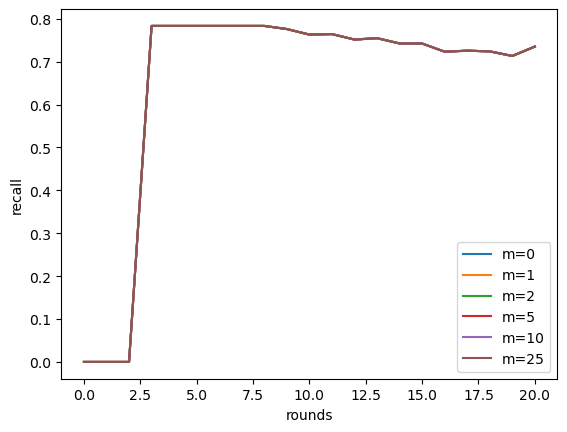

In [13]:
history_files = [
    'hist_1680168537_adaptive_target_0.5_init_clip_norm_2_lr_0.2_noise_0.json',
    'hist_1680169020_adaptive_target_0.5_init_clip_norm_2_lr_0.2_noise_0.json',
    'hist_1680169323_adaptive_target_0.5_init_clip_norm_2_lr_0.2_noise_0.json',
    'hist_1680169635_adaptive_target_0.5_init_clip_norm_2_lr_0.2_noise_0.json',
    'hist_1680169958_adaptive_target_0.5_init_clip_norm_2_lr_0.2_noise_0.json',
    'hist_1680170270_adaptive_target_0.5_init_clip_norm_2_lr_0.2_noise_0.json'
]
for fname, m in zip(history_files, [0, 1, 2, 5, 10, 25]):
    with open(home_dir / 'histories' / fname) as f:
        hist = json.load(f)
    recall = list(map(lambda val: val[1], hist['metrics_centralized']['recall']))
    print(recall[-1])
    plt.plot(recall, label=f'm={m}')
plt.xlabel('rounds')
plt.ylabel('recall')
plt.legend()
plt.show()